In [13]:
import os, shutil
import pandas as pd
import numpy as np
import keras 
from keras.models import Model, Sequential
directory = r'D:\Machine Learning\10-monkey-species'
labels = directory +'\monkey_labels.txt'


# This is a Convolutional Neural Network meant to classify the images of 10 different types of
# Monkey Species. 


# Columns in original dataset had spaces and other formatting issues, so this is re-applying 
# the headers:
columns = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
monkey_labels = pd.read_csv(labels,names=columns, skiprows=1)
print(monkey_labels.info())
print(list(monkey_labels))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
Label                10 non-null object
Latin Name           10 non-null object
Common Name          10 non-null object
Train Images         10 non-null int64
Validation Images    10 non-null int64
dtypes: int64(2), object(3)
memory usage: 480.0+ bytes
None
['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']


In [14]:
### BUILDING THE NEURAL NETWORK ###

from keras import layers, optimizers
from keras.layers import Input, SeparableConv2D, Flatten
from keras.models import Model
from keras.utils import plot_model
from keras.applications import VGG19

### EXPLANATION OF NETWORK ARCHITECTURE ###

# I initially tried several approaches for the network architecture, including using a SeparableConv2D
# instead of a normal Conv2D, and many many combinations of Conv2D/Maxpooling/Batch Normalization/
# Dropout along with trying various combinations of their parameters. After much testing I was 
# struggling to get above 65% accuracy. I determined that due to the very small dataset size I would
# go with a transfer learning approach using the VGG19 network pre-trained on the huge ImageNet dataset.
# I figured the pre-trained model would do a much better job of identifying the Monkey species.
# This proved to be correct, boosting the accuracy of the model by around 10-15%.



# instantiating the VGG19 pre-trained network in order to use its weights to boost model accuracy.
# 'include_top = False' is to remove the Dense layers at the top of the network so I can replace it
# with my own trainable Dense layers.
pre_trained_conv_base = VGG19(weights ='imagenet',
                             include_top = False)


# Building the network using the Keras Functional API instead of the Sequential Model
inputs = Input(shape=(150,150,3))
x = pre_trained_conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)



# By setting this to False, the original weights in the pre-trained VGG19 network are maintained.
# Without setting this to False the backpropagation will ruin/scramble all the previously 
# learned weights from the VGG19 network greatly affecting model accuracy.
pre_trained_conv_base.trainable = False

# Using 'categorical_crossentropy' because we have 10 classes/categories:
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])


print(model.summary())

# Note that we have 20 million Non-trainable parameters because I locked the VGG19 base.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 21,074,378
Trainable params: 1,049,994
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [15]:
### Data Augmentation and Generators ###

from keras.preprocessing.image import ImageDataGenerator

# Augmenting the training Data because the original dataset is small, only around 100 
# training images per class.

#Only augment training data, NOT validationn or test data:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 40,
                                  width_shift_range =0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                   zoom_range = 0.3,
                                   horizontal_flip=True,
                                  fill_mode='nearest')

# Don't augment the validation set:
val_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32

# Directories to training and validation sets:
train_dir = r'D:\Machine Learning\10-monkey-species\training\training'
val_dir = r'D:\Machine Learning\10-monkey-species\validation\validation'

# Generators:
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size =(150,150),
                    batch_size=batch_size,
                    class_mode='categorical',
                    seed=1337)
val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size =(150,150),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False,
                    seed=1337)

train_num = train_generator.samples
val_num = val_generator.samples 

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [16]:
### CALLBACKS ###
from keras import callbacks

# Creating the path to save the best model learned:
filepath=str(os.getcwd()+"/best monkey model.h5f")


# ReduceLROnPlateau - will decrease the learning rate by a factor of 0.2 if the validation
# set loss does not decrease for two epochs, it will maintain the decreased learning rate 
# for 3 epochs in order to try to get out of a potential local Minima 
#
# ModelCheckpoint - saves the best model based off validation set accuracy

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor = 0.2,
                                                     patience = 2,
                                                      cooldown=3),
                    keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                     monitor='val_acc',
                                                    verbose=1,
                                                     save_best_only=True,
                                                    mode='max')]


In [17]:
### TRAINING THE NETWORK ###

history = model.fit_generator(train_generator,
                             steps_per_epoch = (train_num // batch_size),
                             epochs=40,
                             validation_data=val_generator,
                              callbacks=callbacks,
                             validation_steps=val_num // batch_size)



Epoch 1/40
34/34 [==============================] - 225s 7s/step - loss: 2.1811 - acc: 0.2537 - val_loss: 1.5489 - val_acc: 0.4648

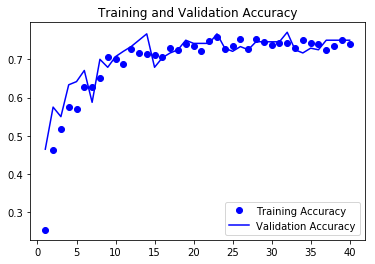

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs,val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

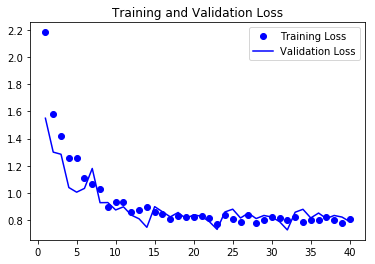

In [19]:
plt.plot(epochs,loss, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

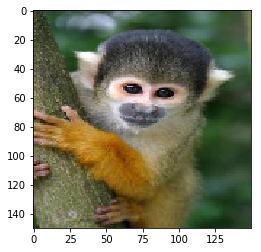

In [20]:
from keras.preprocessing.image import image

# I have taken a test image from the 'Common Squirrel Monkey' class for 
# a quick prediction testing to spot check if the models learned make sense:
img_path= r'D:\Machine Learning\10-monkey-species\n7test.jpg'

test_image = image.load_img(img_path,target_size=(150,150))

#img_to_array turns the picture into a tensor:
img_tensor = image.img_to_array(test_image)

# Expanding the dimension since Keras need this to be 3 dimensional:
img_tensor =np.expand_dims(img_tensor,axis=0)
img_tensor /= 255.


plt.imshow(img_tensor[0])
plt.show()


In [21]:
from keras.models import load_model
from keras import models

best_model = load_model('best monkey model.h5f')


preds = best_model.predict(img_tensor)


print('Highest Value for Prediction: ' + str(np.amax(preds))+'\n'+ 'This value belongs to class: '+ str(np.argmax(preds)))
print('Class '+ str(np.argmax(preds)) + ' is ' + ' '+ monkey_labels['Common Name'][np.argmax(preds)] )


# The model correctly predicts this to be a Common Squirrel Monkey with 92% confidence.

C:\Users\Adam\Desktop\WinPython-64bit-3.5.3.0Qt5\python-3.5.3.amd64\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Highest Value for Prediction: 0.9199808
This value belongs to class: 7
Class 7 is   common_squirrel_monkey        


"\nlayer_outputs = [layer.output for layer in best_model.layers[:8]]\nactivation_model = models.Model(inputs=best_model.input,outputs=layer_outputs)\n\nactivations = activation_model.predict(img_tensor)\n\nfirst_layer_activation = activations2[1]\n\nplt.matshow(first_layer_activation[0,:,:,4],cmap='viridis')\n\n"

In [23]:
### EVALUATION OF MODEL ###

import sklearn
from sklearn.metrics import confusion_matrix, classification_report


Y_pred = model.predict_generator(val_generator, number_of_test_samples // batch_size+1)

#this takes the highest value in the array ie: its best prediction score
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = monkey_labels['Common Name']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))


272
272
False
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9]
9/9 [==============================] - 48s 5s/step
No of erro